# ARIMA model implementation using Python

### Import packages
The basic packages like numpy and pandas for dealing with data are imported. For visualization, matplotlib is used. And to implement ARIMA model, the statsmodel is imported.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 

### Analyzing data
The data which is used is seasonal data of electricity production.

In [2]:
df = pd.read_csv('Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


The column names are changed for ease of use.

In [3]:
df.columns = ['Date','Production']
df.head()

,Date,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


Now to work with time series data, the 'date' column is converted into datetime index.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [5]:
df.set_index('Date',inplace=True)
df.head()

,Production
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Visualization of data

<AxesSubplot:xlabel='Date'>

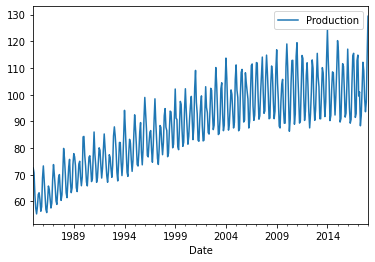

In [6]:
df.plot()

As seen from the plot, this is a seasonal dat as there is some seasonality to it and a upward trend too. 

Now comparing the 12 month simple moving average along with the series to ascertain the trend. The standard deviation is also plotted to see if there is any variance or no.

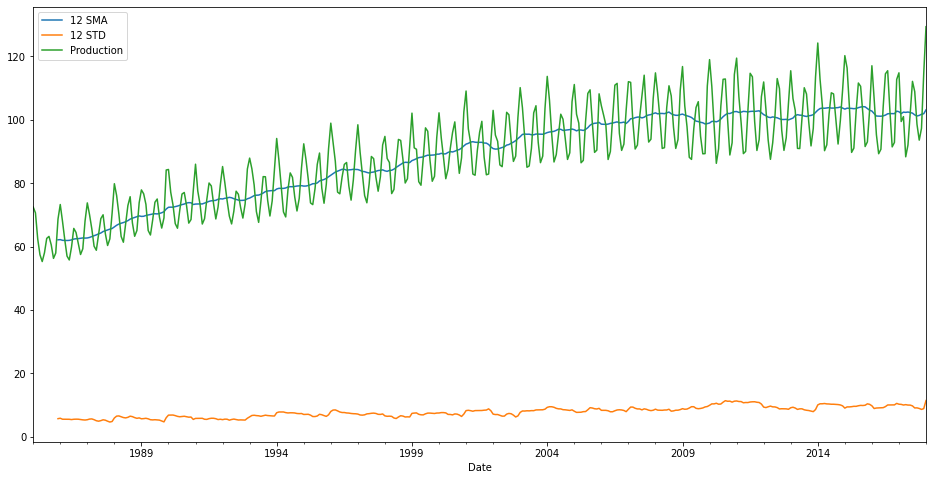

In [7]:
df['Production'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df['Production'].rolling(12).std().plot(label='12 STD')
df['Production'].plot()
plt.legend()

A s seen from the above plot, the standard deviation is not varying much so there is not much variance.

### Decomposition of the time series data to its trend, seasonality and residual components.

statsmodels is used for the decomposition.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

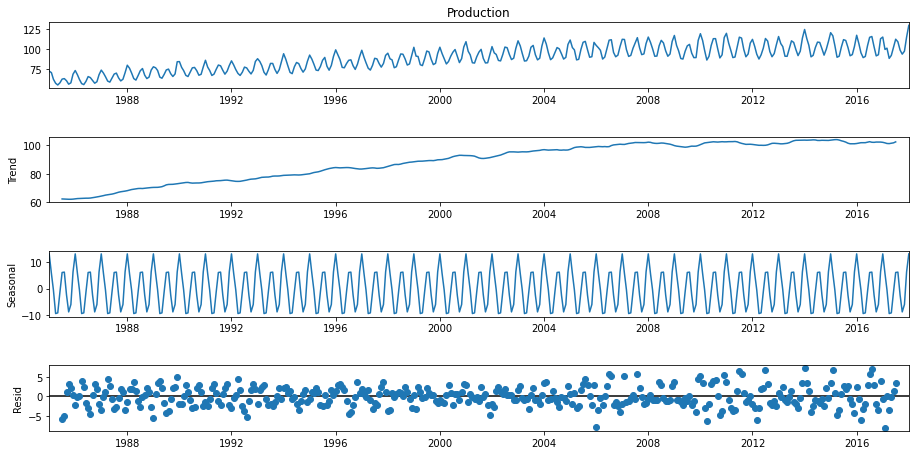

In [9]:
decomp = seasonal_decompose(df['Production'])
fig = decomp.plot()
fig.set_size_inches(14,7)

The trend, seasonal and residual errors can be seen individually here.

### Converting the data into stationary form

The data is first tested using the Dickey-Fuller test to check if the data is in stationary form or no and then change its form.

The Dickey–Fuller has the null hypothesis that a unit root is present and it is a non-stationary time series. The alternative hypothesis is that there is no unit root and the series is stationary.

We will test with the help of the parameter 'p'. If p is small (p<=0.05), we reject the null hypothesis, otherwise not reject the null hypothesis. 

From the statsmodels package, the augmented dickey-fuller test function is imported. It return a tuple which consists of the values: adf, pvalue, usedlag, nobs, critical values, icbest and resstore.

In [10]:
from statsmodels.tsa.stattools import adfuller

Then this function is called on the production column of the dataset.

In [11]:
fuller_test = adfuller(df['Production'])
fuller_test   

(-2.256990350047239,
 0.18621469116586975,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

Now the p-value is printed and using the p value, it is ascertained if data is stationary or not.

In [12]:
def test_p_value(data):
    fuller_test = adfuller(data)
    print('P-value: ',fuller_test[1])
    if fuller_test[1] <= 0.05:
        print('Reject null hypothesis, data is stationary')
    else:
        print('Do not reject null hypothesis, data is not stationary')
        
test_p_value(df['Production'])

P-value:  0.18621469116586975
Do not reject null hypothesis, data is not stationary


Since the data is not stationary, differencing is carried out. The difference is the change of the time series from one period to next. The first difference, second difference and seasonal difference is calculated and for each the p-value is checked.

<AxesSubplot:xlabel='Date'>

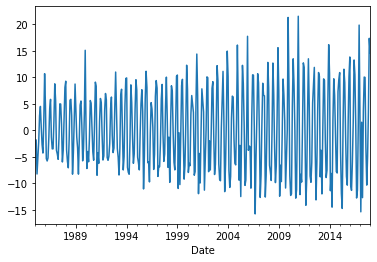

In [13]:
df['First_diff'] = df['Production'] - df['Production'].shift(1)
df['First_diff'].plot()

In [14]:
test_p_value(df['First_diff'].dropna())

P-value:  4.0777865655398996e-10
Reject null hypothesis, data is stationary


In the first difference, we got the data in stationary form. Incase, a second difference was needed then the following would have been done.

<AxesSubplot:xlabel='Date'>

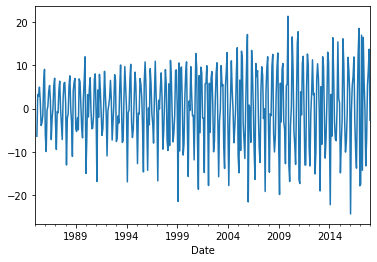

In [15]:
df['Second_diff'] = df['First_diff'] - df['First_diff'].shift(1)
df['Second_diff'].plot()

In [16]:
test_p_value(df['Second_diff'].dropna())

P-value:  4.1836937480000375e-17
Reject null hypothesis, data is stationary


A seasonal difference can also be taken as follows. The shifting will happen by an entire season that is '12'.

<AxesSubplot:xlabel='Date'>

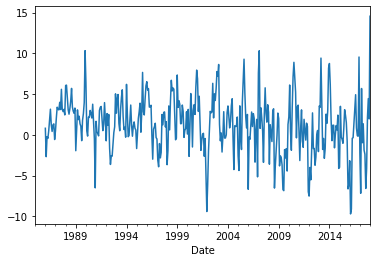

In [17]:
df['Seasonal_diff'] = df['Production'] - df['Production'].shift(12)
df['Seasonal_diff'].plot()

In [18]:
test_p_value(df['Seasonal_diff'].dropna())

P-value:  8.812644938089026e-07
Reject null hypothesis, data is stationary


### Plotting the ACF and PACF plot

From the statsmodels package the ACF and PACF plot fucntions are imported.

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

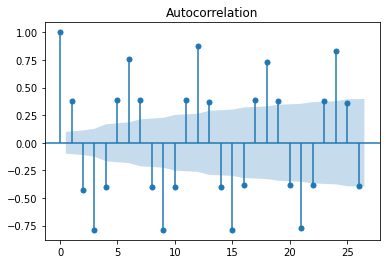

In [20]:
first_diff = plot_acf(df['First_diff'].dropna())

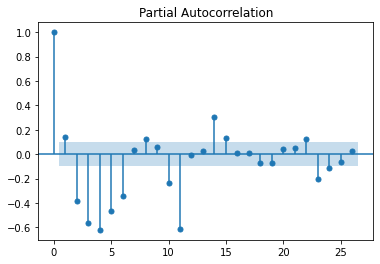

In [21]:
sec_diff = plot_pacf(df['Second_diff'].dropna())

Now the final ACF and PACF plots will be plotted which will be used further.

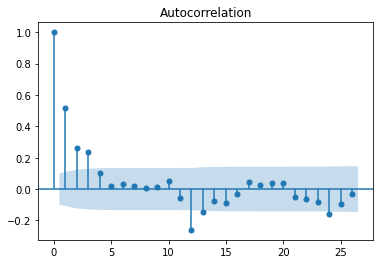

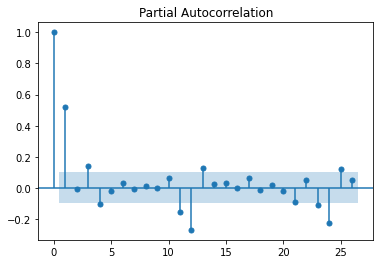

In [22]:
p1 = plot_acf(df['Seasonal_diff'].dropna())
p2 = plot_pacf(df['Seasonal_diff'].dropna())

### Constructing the ARIMA model

For non-seasonal data the ARIMA model can be imported from statsmodels module.

In [23]:
from statsmodels.tsa.arima_model import ARIMA

For seasonal data, the seasonal ARIMA model can be imported from the statsmodels module. The data used here is seasonal data so the seasonal ARIMA model is imported. The arguements passed are production column, order and seasonal order. 

order: The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.

seasonal order: The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In [24]:
model = sm.tsa.statespace.SARIMAX(df['Production'],order=(0,1,0),seasonal_order=(1,1,1,12))

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Once the model is created, the next thing to do is to fit the model.

In [25]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  397
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -928.856
Date:                              Sat, 13 Feb 2021   AIC                           1863.712
Time:                                      14:08:25   BIC                           1875.564
Sample:                                  01-01-1985   HQIC                          1868.413
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0421      0.058      0.721      0.471      -0.072       0.157
ma.S.L12      -0.7790      0.041    -19.119      0.000      -0.859      -0.699
sigma2         7.1906      0.417     17.245      0.000       6.373       8.008
===================================================================================
Ljung-Box (Q):                       99.01   Jarque-Bera (JB):                30.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

To know about the residuals values or error, the 'resid' method can be called on the results.

In [26]:
results.resid

Date
1985-01-01    72.505200
1985-02-01    -1.833200
1985-03-01    -8.221800
1985-04-01    -4.978800
1985-05-01    -2.156300
                ...    
2017-09-01     0.529985
2017-10-01     4.057874
2017-11-01     0.690663
2017-12-01     2.477697
2018-01-01     6.953533
Length: 397, dtype: float64

<AxesSubplot:xlabel='Date'>

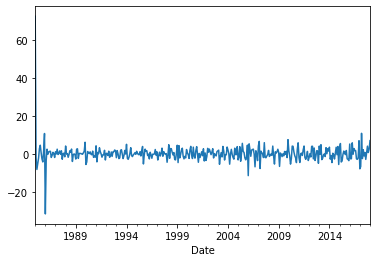

In [27]:
results.resid.plot()

The distribution of the errors can be seen by plotting the KDE. And as seen from the plot below, the errors are distributed around 0 which is good.

<AxesSubplot:ylabel='Density'>

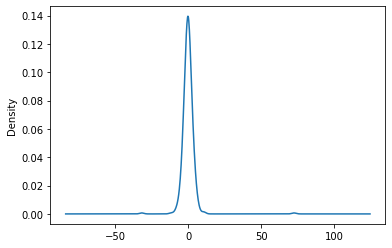

In [28]:
results.resid.plot(kind='kde')

### Predicting or forecasting

By predicting the values, the model's performance can be ascertained. First we can look into how it predicts for the data present and then move onto predicting future data.

<AxesSubplot:xlabel='Date'>

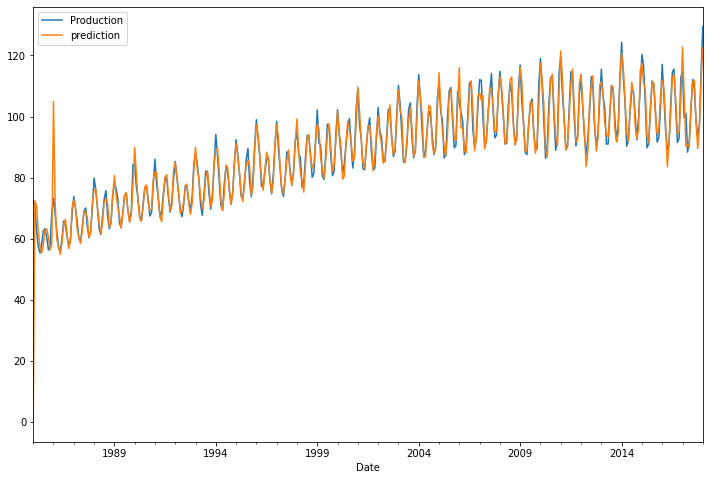

In [29]:
df['prediction'] = results.predict()
df[['Production','prediction']].plot(figsize=(12,8))

As seen from the above plot, the model does a good job is predicting for the present data. Now to predict for the future, we can add more months to the dataset with null values and predict for it. This can be done using pandas. The last index is obtained which is the last date and a month offset is added to it which starts from 1 and goes up to 24.

In [30]:
df.tail()

,Production,First_diff,Second_diff,Seasonal_diff,prediction
Date,,,,,
2017-09-01,98.6154,-10.3158,-7.0932,-4.1483,98.085415
2017-10-01,93.6137,-5.0017,5.3141,2.1270,89.555826
2017-11-01,97.3359,3.7222,8.7239,4.4459,96.645237
2017-12-01,114.7212,17.3853,13.6631,1.9518,112.243503
2018-01-01,129.4048,14.6836,-2.7017,14.5543,122.451267


In [31]:
from pandas.tseries.offsets import DateOffset

In [32]:
extra_dates = [df.index[-1] + DateOffset(months=m) for m in range (1,24)]
extra_dates

[Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

Now another dataframe is created with these extra future date values as index and the rest of the column values as null.

In [33]:
forecast_df = pd.DataFrame(index=extra_dates,columns=df.columns)
forecast_df.head()

,Production,First_diff,Second_diff,Seasonal_diff,prediction
2018-02-01,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN
2018-06-01,NaN,NaN,NaN,NaN,NaN


Now the original dataframe and this forecast dataframe is concatenated into a single one for forecasting.

In [34]:
final_df = pd.concat([df,forecast_df])
final_df.tail()

,Production,First_diff,Second_diff,Seasonal_diff,prediction
2019-08-01,NaN,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN,NaN,NaN


Now we can predict the values for the end data points by mentioning the start and end arguments while calling the 'predict' function.

<AxesSubplot:>

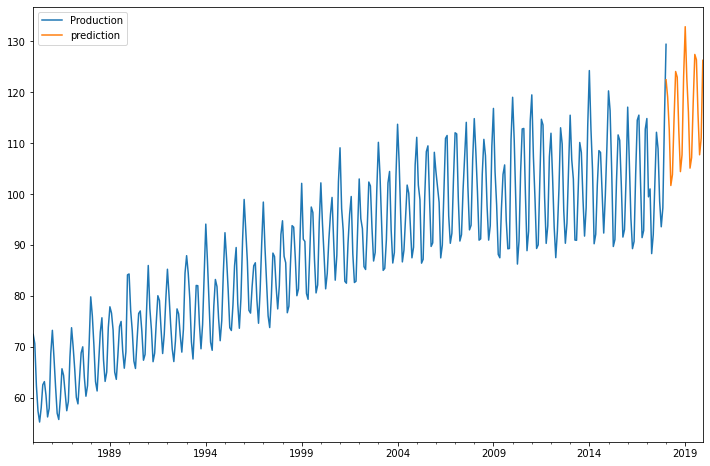

In [35]:
final_df['prediction'] = results.predict(start=396, end=430)
final_df[['Production','prediction']].plot(figsize=(12,8))

The prediction line can be seen clearly for the future values.